In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

In [3]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)}
}

In [41]:
checkpoint = torch.load("/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/model_30.pth")
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.load_state_dict(new_state_dict)
model.to(device)

LearnedSimulator_periodic(
  (graph_network): EncodeProcessDecode(
    (_encoder_network): GraphIndependent(
      (edge_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=1, bias=True)
        )
        (1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
      )
      (node_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=22, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (_processor_networks): ModuleList(
      (0): GNNModel(
        (gcn_layers): ModuleList(
          (0-14): 15 x NodeGNN()
        )
      )
    )
    (_decoder_network): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_fe

In [42]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float32).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [43]:
def create_csv_with_predictions(model,n_cells, device, input_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-vrai_pos[-2])[:n_cells]*1e3,pos[-1],vrai_pos[-1])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
    return loss,norm_acc

In [44]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_5.csv",200)

tensor([[-0.0096,  0.0345],
        [-0.0374, -0.0259],
        [ 0.1471, -0.0976],
        [-0.0687, -0.0606],
        [ 0.1054,  0.1071],
        [ 0.0108,  0.0221],
        [-0.1089, -0.0127],
        [ 0.1055,  0.0066],
        [-0.1321,  0.0325],
        [-0.0091, -0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-0.0657393   0.22330091]
 [-0.2313195  -0.1405411 ]
 [ 0.8932702  -0.5996084 ]
 [-0.4084741  -0.3383836 ]
 [ 0.640949    0.6761551 ]
 [ 0.0660492   0.136315  ]
 [-0.6580542  -0.0616453 ]
 [ 0.6312394   0.0563376 ]
 [-0.7985377   0.19913203]
 [-0.0693832  -0.1510623 ]] [[ 0.6386141   0.01336312]
 [-0.82418853  0.5705732 ]
 [-0.3145014   0.62184924]
 [ 0.83544326 -0.44691467]
 [-0.60817313  0.7229379 ]
 [-0.29908353 -0.10667872]
 [-0.96059674 -0.92556745]
 [-0.7393321  -0.3036006 ]
 [ 0.4464601   0.05894663]
 [ 0.3720024   0.8534714 ]
 [ 0.6386141   2.013363  ]
 [-0.82418853  2.570573  ]
 [-0.3145014   2.6218493 ]
 [ 0.83544326  1.5530852 ]
 [-0.60817313  2.7229378 ]


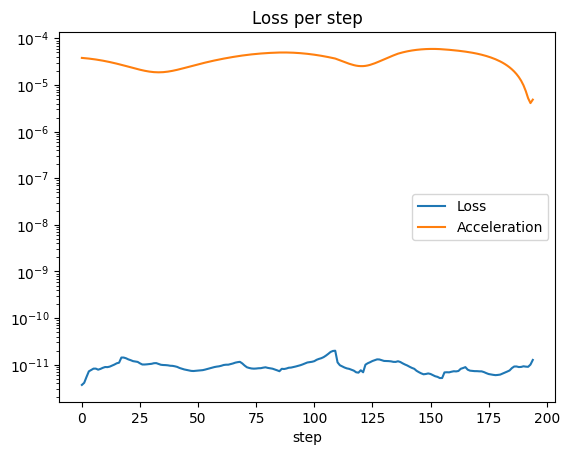

In [45]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [46]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3)
        if step%1==0:
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [47]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_5.csv", "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/computed_trajectories/computed_positions_5.csv",205)

tensor([[-0.0096,  0.0345],
        [-0.0374, -0.0259],
        [ 0.1471, -0.0976],
        [-0.0687, -0.0606],
        [ 0.1054,  0.1071],
        [ 0.0108,  0.0221],
        [-0.1089, -0.0127],
        [ 0.1055,  0.0066],
        [-0.1321,  0.0325],
        [-0.0091, -0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-0.0105277   0.03669222]
 [-0.0373897  -0.0232698 ]
 [ 0.1461949  -0.097561  ]
 [-0.0676416  -0.0556874 ]
 [ 0.105184    0.1100962 ]
 [ 0.010386    0.0225307 ]
 [-0.1076985  -0.0103315 ]
 [ 0.1038601   0.0101053 ]
 [-0.1315119   0.03271642]
 [-0.0108559  -0.0252913 ]]
tensor([[-0.0095,  0.0338],
        [-0.0381, -0.0262],
        [ 0.1446, -0.0977],
        [-0.0690, -0.0604],
        [ 0.1068,  0.1068],
        [ 0.0108,  0.0223],
        [-0.1084, -0.0116],
        [ 0.1055,  0.0050],
        [-0.1321,  0.0323],
        [-0.0082, -0.0253]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-0.0102728   0.03638246]
 [-0.0367179  -0.0231679 ]
 [ 0.1446319  -0.0961376 ]


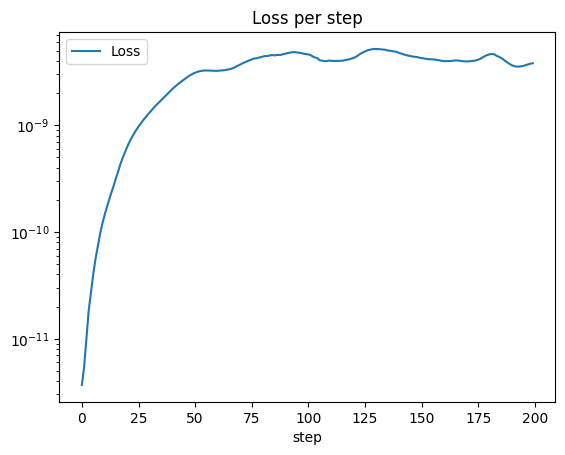

In [48]:
plt.plot(loss, label='Loss')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()